In [17]:
import csv

import joblib
import numpy as np
from mplfonts import use_font
import numpy as np

# plt.style.use("seaborn-v0_8-whitegrid")
use_font("Noto Serif CJK SC")
eps = 1e-6


def score_func_precision_recall(eval_result_path, outputpath, sigmoid=True):
    data = joblib.load(eval_result_path)
    y_pred, y_true, unmon_label = data["y_pred"], data["y_true"], data["unmonitored_label"]
    if sigmoid:
        y_pred = np.exp(y_pred) / (np.exp(y_pred).sum(axis=1)).reshape(-1, 1)
    file = open(outputpath, "w+", encoding="utf-8", newline="")
    csvwirter = csv.writer(file)
    upper_bound = 1.0
    thresholds = upper_bound - upper_bound / np.logspace(0.05, 2, num=15, endpoint=True)
    csvwirter.writerow(["TH", "TP", "TN", "FP", "FN", "WP", "Precision", "Recall"])
    fmt_str = "{:.2f}:\t{}\t{}\t{}\t{}\t{:.3f}\t{:.3f}"

    # evaluate list performance at different thresholds
    # high threshold will yield higher precision, but reduced recall
    for TH in thresholds:
        TP, FP, TN, FN, WP = 0, 0, 0, 0, 0

        # Test with Monitored testing instances
        for i in range(len(y_pred)):
            ground_truths = y_true.argmax(axis=1)[i]
            sm_vector = y_pred[i]
            predicted_class = np.argmax(sm_vector)
            max_prob = max(sm_vector)
            if ground_truths != unmon_label:
                if predicted_class == ground_truths:  # predicted as Monitored
                    if max_prob >= TH:  # predicted as Monitored and actual site is Monitored
                        TP = TP + 1
                    else:  # predicted as Unmonitored and actual site is Monitored
                        FN = FN + 1
                else:  # predicted as Unmonitored and actual site is Monitored
                    FN = FN + 1
            else:
                if predicted_class != unmon_label:  # predicted as Monitored
                    if max_prob >= TH:  # predicted as Monitored and actual site is Unmonitored
                        FP = FP + 1
                    else:  # predicted as Unmonitored and actual site is Unmonitored
                        TN = TN + 1
                else:  # predicted as Unmonitored and actual site is Unmonitored
                    TN = TN + 1

        res = [
            TH,
            TP,
            TN,
            FP,
            FN,
            WP,
            float(TP) / (TP + FP + eps),
            float(TP) / (TP + FN + eps),
        ]
        print(fmt_str.format(*res))
        csvwirter.writerow(res)

    file.close()
    return outputpath


import matplotlib.pyplot as plt
import pandas as pd


def draw_pr_curve(csv_paths, labels=None):
    fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
    for i, csv_path in enumerate(csv_paths):
        df = pd.read_csv(csv_path)
        ax.plot(
            df["Recall"],
            df["Precision"],
            label=labels[i] if labels else csv_path.stem,
            lw=2,
            marker="o",
            markersize=4,
        )
    plt.legend()
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.1, 1.05])
    plt.xlabel("召回率")
    plt.ylabel("精确度")
    plt.title("精确度-召回率曲线（P-R Curve）")
    plt.savefig("pr_curve.pdf")
    return

In [7]:
from pathlib import Path

root = Path("run/test/20240611bacow/sdfow")
log = Path("log")
result = []
for attack in ["DF"]:
    for pkl in [
        "empty/empty.pkl",
        "front_4250/front_4250.pkl",
        "regulator/regulator.pkl",
        "pred300_security_7_data_vs_time_20/pred300_security_7_data_vs_time_20.pkl",
        "gan300_tol6/gan300_tol6.pkl",
        "tamaraw_2_6/tamaraw_2_6.pkl",
    ]:
        name = attack + "-" + Path(pkl).stem

        result.append(score_func_precision_recall(root / attack / pkl, log / name, sigmoid=False))

0.11:	1811	3879	88	122	0.000	0.954
0.35:	1811	3880	87	122	0.000	0.954
0.53:	1807	3888	79	126	0.000	0.958
0.66:	1800	3894	73	133	0.000	0.961
0.75:	1796	3898	69	137	0.000	0.963
0.82:	1792	3903	64	141	0.000	0.966
0.87:	1789	3909	58	144	0.000	0.969
0.91:	1788	3912	55	145	0.000	0.970
0.93:	1786	3915	52	147	0.000	0.972
0.95:	1783	3918	49	150	0.000	0.973
0.96:	1779	3921	46	154	0.000	0.975
0.97:	1778	3925	42	155	0.000	0.977
0.98:	1773	3927	40	160	0.000	0.978
0.99:	1771	3927	40	162	0.000	0.978
0.99:	1767	3929	38	166	0.000	0.979
0.11:	729	3158	809	1204	0.000	0.474
0.35:	728	3161	806	1205	0.000	0.475
0.53:	716	3213	754	1217	0.000	0.487
0.66:	695	3306	661	1238	0.000	0.513
0.75:	683	3371	596	1250	0.000	0.534
0.82:	663	3427	540	1270	0.000	0.551
0.87:	642	3461	506	1291	0.000	0.559
0.91:	631	3502	465	1302	0.000	0.576
0.93:	617	3534	433	1316	0.000	0.588
0.95:	603	3558	409	1330	0.000	0.596
0.96:	594	3597	370	1339	0.000	0.616
0.97:	573	3613	354	1360	0.000	0.618
0.98:	560	3639	328	1373	0.000	0.631
0.99:	5

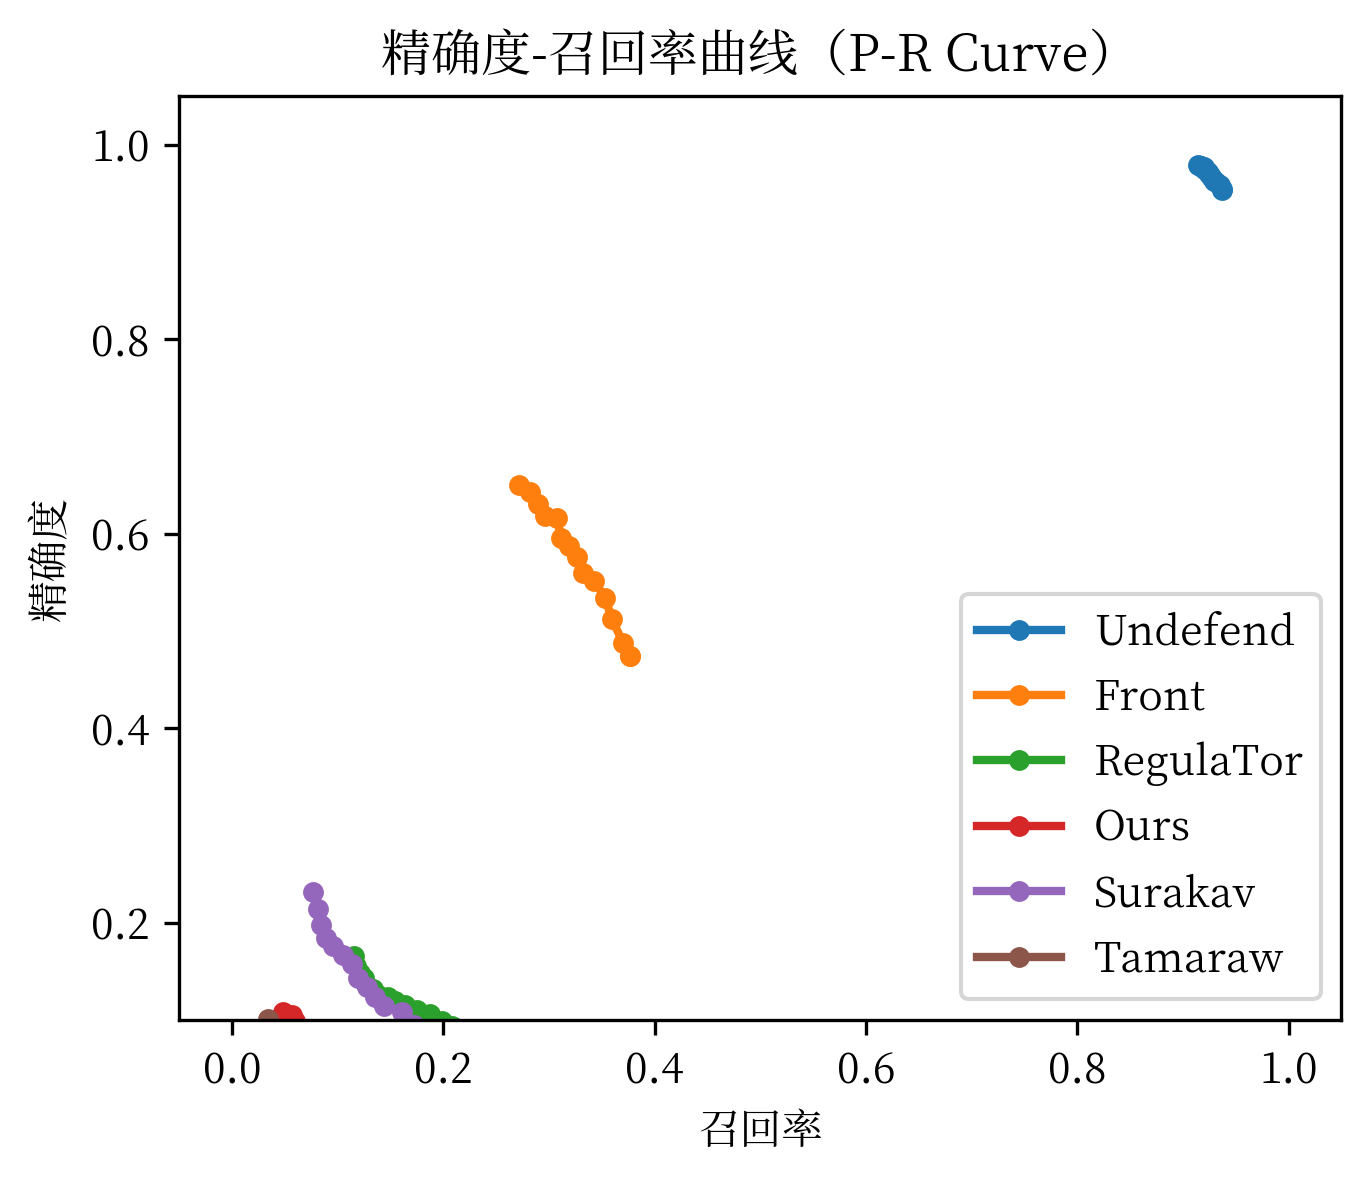

In [19]:
result = []
for attack in ["DF"]:
    for pkl in [
        "empty/empty.pkl",
        "front_4250/front_4250.pkl",
        "regulator/regulator.pkl",
        "pred300_security_7_data_vs_time_20/pred300_security_7_data_vs_time_20.pkl",
        "gan300_tol6/gan300_tol6.pkl",
        "tamaraw_2_6/tamaraw_2_6.pkl",
    ]:
        name = attack + "-" + Path(pkl).stem
        result.append(log / name)
labels = [f.stem for f in result]
for i in range(len(labels)):
    if "gan" in labels[i]:
        labels[i] = "Surakav"
    elif "front" in labels[i]:
        labels[i] = "Front"
    elif "tamaraw" in labels[i]:
        labels[i] = "Tamaraw"
    elif "regu" in labels[i]:
        labels[i] = "RegulaTor"
    elif "pred" in labels[i]:
        labels[i] = "Ours"
    elif "empty" in labels[i]:
        labels[i] = "Undefend"
draw_pr_curve(result, labels)